## Ebola infected Macaque Sample Composition Trajectory Identification

```
Indices:

- c cell type
- g genes
- m samples
- k deformation polynomial degree
```

In [43]:
import os
import pickle5
import numpy as np
import pandas as pd
#import matplotlib.pylab as plt
import matplotlib
import matplotlib.pyplot
from typing import Dict
from pyro.distributions.torch_distribution import TorchDistribution, TorchDistributionMixin
from torch.distributions.utils import probs_to_logits, logits_to_probs, broadcast_all, lazy_property
from torch.distributions import constraints
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from typing import List, Dict
from boltons.cacheutils import cachedproperty
from pyro.distributions.torch_distribution import TorchDistribution, TorchDistributionMixin
from torch.distributions.utils import probs_to_logits, logits_to_probs, broadcast_all, lazy_property
from torch.distributions import constraints
from numbers import Number
import pyro.distributions as dist
import anndata

## Parameter Configuration

In [44]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

## Helper functions and Classes

In [45]:
def NegativeBinomialAltParam(mu, phi):
    """
    Creates a negative binomial distribution.
    
    Args:
        mu (Number, Tensor): mean (must be strictly positive)
        phi (Number, Tensor): overdispersion (must be strictly positive)
    """
    return dist.GammaPoisson(
            concentration= 1 /phi ,
            rate=1 / (mu * phi))

In [46]:
class DeconvolutionDataset:
    """This class represents a bulk and single-cell dataset to be deconvolved in tandem"""
    
    def __init__(
            self,
            sc_anndata: anndata.AnnData,
            sc_celltype_col: str,
            bulk_anndata: anndata.AnnData,
            bulk_time_col: str,
            dtype_np: np.dtype):

        self.dtype_np = dtype_np
        self.sc_celltype_col = sc_celltype_col
        self.bul_time_col = bulk_time_col

        self.bulk_anndata = bulk_anndata
        self.sc_anndata = sc_anndata
        
        # Select common genes and subset/order anndata objects
        common_genes = list(set(self.bulk_anndata.obs.index).intersection(set(self.sc_anndata.obs.index)))
        self.num_genes = len(common_genes)
        self.bulk_anndata = self.bulk_anndata[common_genes,:]
        self.sc_anndata = self.sc_anndata[common_genes,:]
        
        # TODO: Issue warning if too many genes removed
        
        # Pre-process time values and save inverse function
        self.dpi_time_original_m = self.bulk_anndata.var[bulk_time_col].values.astype(dtype_np)
        self.time_min = np.min(self.dpi_time_original_m)
        self.time_range = np.max(self.dpi_time_original_m) - self.time_min
        self.dpi_time_m = (self.dpi_time_original_m - self.time_min) / self.time_range
        
        
    @cachedproperty
    def cell_type_str_list(self) -> List[str]:
        return sorted(list(set(self.sc_anndata.var[self.sc_celltype_col])))
    
    @cachedproperty
    def cell_type_str_to_index_map(self) -> Dict[str, int]:
        return {cell_type_str: index for index, cell_type_str in enumerate(self.cell_type_str_list)}        
    
    @cachedproperty
    def num_cell_types(self) -> int:
        return len(self.cell_type_str_list)
    
    @cachedproperty
    def w_hat_gc(self) -> np.ndarray:
        """Calculate the estimate cell profiles"""
        w_hat_gc = np.zeros((self.num_genes, self.num_cell_types))
        for cell_type_str in self.cell_type_str_list:
            i_cell_type = self.cell_type_str_to_index_map[cell_type_str]
            mask_j = self.sc_anndata.var[self.sc_celltype_col].values == cell_type_str
            w_hat_gc[:, i_cell_type] = np.sum(self.sc_anndata.X[:, mask_j], axis=-1)
            w_hat_gc[:, i_cell_type] = w_hat_gc[:, i_cell_type] / np.sum(w_hat_gc[:, i_cell_type])
        return w_hat_gc
    
    @cachedproperty
    def bulk_raw_gex_gm(self) -> torch.tensor:
        return torch.tensor(self.bulk_anndata.X, device=device, dtype=dtype)
    
    @cachedproperty
    def t_m(self) -> torch.tensor:
        return torch.tensor(self.dpi_time_m, device=device, dtype=dtype)


In [47]:
def generate_batch(
    dataset: DeconvolutionDataset,
    device: torch.device,
    dtype: torch.dtype):
    
    return {
        "x_mg": torch.tensor(dataset.bulk_raw_gex_gm.T, device=device, dtype=dtype),
        "t_m": torch.tensor(dataset.dpi_time_m, device=device, dtype=dtype),
    }

## Model Definition

In [48]:
class TimeRegularizedDeconvolution:
    
    def  __init__(
            self,
            dataset: DeconvolutionDataset,
            polynomial_degree: int,
            device: device,
            dtype: dtype):
        
        self.dataset = dataset
        self.device = device
        self.dtype = dtype
        self.polynomial_degree = polynomial_degree
        
        # hyperparameters
        self.log_beta_prior_scale = 1.0
        self.log_r_prior_scale = 1.0
        self.tau_prior_scale = 1.0
        self.log_phi_prior_loc = -5.0
        self.log_phi_prior_scale = 1.0
        
        self.unnorm_cell_pop_base_prior_loc_c = np.zeros((self.dataset.num_cell_types,))
        self.unnorm_cell_pop_base_prior_scale_c = np.ones((self.dataset.num_cell_types,))

        # dist of coefficients of population deformation polynomial
        self.unnorm_cell_pop_deform_prior_loc_ck = np.zeros((self.dataset.num_cell_types, self.polynomial_degree))
        self.unnorm_cell_pop_deform_prior_scale_ck = np.ones((self.dataset.num_cell_types, self.polynomial_degree))


        self.init_posterior_global_scale_factor = 0.05
        
        self.log_beta_posterior_scale = 1.0 * self.init_posterior_global_scale_factor
        self.log_r_posterior_scale = 1.0 * self.init_posterior_global_scale_factor
        self.tau_posterior_scale = 1.0 * self.init_posterior_global_scale_factor
        self.log_phi_posterior_loc = -5.0
        self.log_phi_posterior_scale = 0.1 * self.init_posterior_global_scale_factor
        
        
        self.unnorm_cell_pop_base_posterior_loc_c = np.zeros((self.dataset.num_cell_types,))
        self.unnorm_cell_pop_base_posterior_scale_c = self.init_posterior_global_scale_factor * np.ones((self.dataset.num_cell_types,))
        
        self.unnorm_cell_pop_deform_posterior_loc_ck = np.zeros((self.dataset.num_cell_types, self.polynomial_degree))
        self.unnorm_cell_pop_deform_posterior_scale_ck = self.init_posterior_global_scale_factor *  np.ones((self.dataset.num_cell_types, self.polynomial_degree))
        
        # cache useful tensors
        self.w_hat_gc = torch.tensor(self.dataset.w_hat_gc, device=device, dtype=dtype)
        
    def model(
            self,
            x_mg: torch.Tensor,
            t_m: torch.Tensor):
        """
        :param x_mg: gene expression
        :param t_m: obseration time
        """
        
        # sample log_phi_g
        log_phi_g = pyro.sample(
            'log_phi_g',
            dist.Normal(
                loc=self.log_phi_prior_loc * torch.ones(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype),
                scale=self.log_phi_prior_scale * torch.ones(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype)).to_event(1))
        
        # sample log_beta_g
        log_beta_g = pyro.sample(
            'log_beta_g',
            dist.Normal(
                loc=torch.zeros(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype),
                scale=self.log_beta_prior_scale * torch.ones(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype)).to_event(1))
        
        # sample unnorm_cell_pop_base_c
        unnorm_cell_pop_base_c = pyro.sample(
            'unnorm_cell_pop_base_c',
            dist.Normal(
                loc=torch.tensor(
                    self.unnorm_cell_pop_base_prior_loc_c,
                    device=self.device, dtype=self.dtype),
                scale=torch.tensor(
                    self.unnorm_cell_pop_base_prior_scale_c,
                    device=self.device, dtype=self.dtype)).to_event(1))
        
        # Deformation scale is a learnable parameter now
        unnorm_cell_pop_deform_prior_scale_ck = pyro.param("unnorm_cell_pop_deform_prior_scale_ck",
                        torch.tensor(self.unnorm_cell_pop_deform_prior_scale_ck, 
                        device=self.device,
                        dtype=self.dtype),                          
                        constraint = constraints.positive) 
        
        unnorm_cell_pop_deform_ck = pyro.sample(
            'unnorm_cell_pop_deform_ck',
            dist.Normal(
                loc=torch.tensor(
                    self.unnorm_cell_pop_deform_prior_loc_ck,
                    device=self.device, dtype=self.dtype),
                scale=unnorm_cell_pop_deform_prior_scale_ck).to_event(2))
        
        # calculate useful derived variables
        beta_g = log_beta_g.exp()
        phi_g = log_phi_g.exp()
        
        unnorm_w_gc = self.w_hat_gc * beta_g[:, None]
        w_gc = unnorm_w_gc / unnorm_w_gc.sum(0)

        
        # calculate cell proportion
        tau_km = torch.pow(t_m[None,:], torch.arange(1,self.polynomial_degree + 1,device=self.device)[:,None])  
        deformation_mc = torch.matmul(unnorm_cell_pop_deform_ck, tau_km).transpose(-1,-2)
        cell_pop_unnorm_mc = unnorm_cell_pop_base_c[None,:] + deformation_mc
        cell_pop_mc = torch.nn.functional.softmax(cell_pop_unnorm_mc, dim=-1)

        # calculate mean gene expression
        mu_mg = x_mg.sum(-1)[:, None] * torch.matmul(cell_pop_mc, w_gc.transpose(-1, -2))

        with pyro.plate('batch'):
            # observe gene expression
            pyro.sample(
                "x_mg",
                NegativeBinomialAltParam(
                    mu=mu_mg,
                    phi=phi_g[None, :]).to_event(1),
                obs=x_mg)

    def delta_guide(
            self,
            x_mg: torch.Tensor,
            t_m: torch.Tensor):
        
        # variational parameters for log_phi_g
        log_phi_posterior_loc_g = pyro.param(
            "log_phi_posterior_loc_g",
            self.log_phi_posterior_loc * torch.ones(
                (self.dataset.num_genes,), device=self.device, dtype=self.dtype))

        # variational parameters for log_beta_g
        log_beta_posterior_loc_g = pyro.param(
            "log_beta_posterior_loc_g",
            torch.zeros(
                (self.dataset.num_genes,), device=self.device, dtype=self.dtype))        
        
        # variational parameters for unnorm_cell_pop_base_c ("B_c")
        unnorm_cell_pop_base_posterior_loc_c = pyro.param(
            "unnorm_cell_pop_base_posterior_loc_c",
            torch.tensor(
                self.unnorm_cell_pop_base_posterior_loc_c,
                device=self.device, dtype=self.dtype))
        
        # variational parameters for unnorm_cell_pop_deform_c ("R_c")
        unnorm_cell_pop_deform_posterior_loc_ck = pyro.param(
            "unnorm_cell_pop_deform_posterior_loc_ck",
            torch.tensor(
                self.unnorm_cell_pop_deform_posterior_loc_ck,
                device=self.device, dtype=self.dtype))
        
        # posterior sample statements
        log_phi_g = pyro.sample(
            "log_phi_g",
            dist.Delta(
                v=log_phi_posterior_loc_g).to_event(1))

        log_beta_g = pyro.sample(
            "log_beta_g",
            dist.Delta(
                v=log_beta_posterior_loc_g).to_event(1))

        unnorm_cell_pop_base_c = pyro.sample(
            'unnorm_cell_pop_base_c',
            dist.Delta(
                v=unnorm_cell_pop_base_posterior_loc_c).to_event(1))
        
        unnorm_cell_pop_deform_ck = pyro.sample(
            'unnorm_cell_pop_deform_ck',
            dist.Delta(v=unnorm_cell_pop_deform_posterior_loc_ck).to_event(2))
        
    def fit_model(self, n_iters = 3000, log_frequency = 100, verbose = True):
        pyro.clear_param_store()
        optim = pyro.optim.Adam({'lr': 5e-3})
        
        self.loss_hist = []
        
        svi = SVI(
            model=self.model,
            guide=self.delta_guide,
            optim=optim,
            loss=Trace_ELBO())
        
        for i_iter in range(n_iters):
            batch_dict = generate_batch(self.dataset, device, dtype)
            loss = svi.step(**batch_dict)
            self.loss_hist.append(loss)
            if verbose:
                if i_iter % log_frequency == 0:
                    print(f"{i_iter}   loss: {self.loss_hist[-1]}")
                
    def plot_loss(self):
        fig, ax = matplotlib.pyplot.subplots()
        ax.plot(self.loss_hist)
        ax.set_title('Losses')
        ax.set_xlabel('iteration')
        ax.set_ylabel('ELBO Loss')
        
        return ax
    
    def calculate_composition_trajectories(self, time_step=0.01):
        times_z = torch.arange(0,1,time_step)
        
        # Take time to appropriate exponent
        times_zk = torch.pow(times_z[:,None], torch.arange(1,self.polynomial_degree + 1,))
        
        # get the trained params
        base_composition_post_c = pyro.param("unnorm_cell_pop_base_posterior_loc_c").detach().cpu()
        delta_composition_post_ck = pyro.param("unnorm_cell_pop_deform_posterior_loc_ck").detach().cpu()
        
        # Calculate the deltas for each time point
        delta_cz = torch.matmul(delta_composition_post_ck, times_zk.transpose(-1,-2))
        
        # normalize
        norm_comp_t = torch.nn.functional.softmax(base_composition_post_c[:,None] + delta_cz, dim=0).numpy().T
        
        # calculate true times
        true_times_z = times_z * self.dataset.time_range + self.dataset.time_min
        
        self.calculated_trajectories = {
            "times_z": times_z.numpy(), 
            "true_times_z": true_times_z,
            "norm_comp_t": norm_comp_t
        }
    
    def get_composition_trajectories(self):
        return self.calculated_trajectories
    
    def plot_composition_trajectories(self):
        fig, ax  = matplotlib.pyplot.subplots()
        ax.plot(self.calculated_trajectories["true_times_z"], self.calculated_trajectories["norm_comp_t"])
        ax.set_title("Predicted cell proportions")
        ax.set_xlabel("Time")
        ax.legend(ebov_dataset.cell_type_str_list,loc='best',fontsize='small')

In [49]:
pseudo_time_reg_deconv.dataset.time_min

-30.0

In [50]:
pseudo_time_reg_deconv.dataset.time_range

38.0

## Train Model

In [51]:
bulk_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad"
sc_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [52]:
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata  = anndata.read_h5ad(fh)
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [53]:
bulk_anndata = bulk_anndata[:,bulk_anndata.var['dpi_time'] >= 0,]

In [54]:
ebov_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = bulk_anndata,
    bulk_time_col = "dpi_time",
    dtype_np = dtype_np
)

In [61]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolution(
    dataset=ebov_dataset,
    polynomial_degree = 10,
    device=device,
    dtype=dtype)

In [62]:
pseudo_time_reg_deconv.fit_model(n_iters=1000)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


0   loss: 53814212.31866455
100   loss: 26233440.486718178
200   loss: 15337509.810703278
300   loss: 10091738.998559952
400   loss: 7341275.960107803
500   loss: 5823478.040403366
600   loss: 4937077.439756393
700   loss: 4385697.517356873
800   loss: 4021405.5682811737
900   loss: 3768201.8557243347


## Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

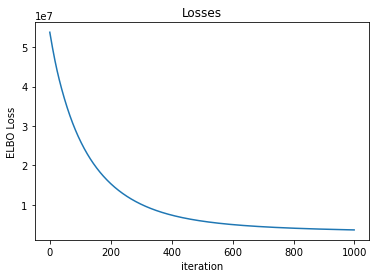

In [63]:
pseudo_time_reg_deconv.plot_loss()

In [64]:
pseudo_time_reg_deconv.calculate_composition_trajectories(time_step=0.01)

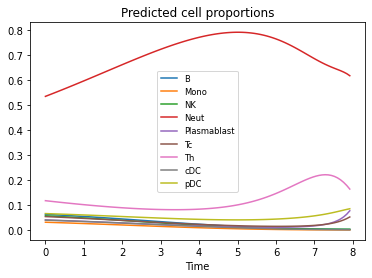

In [65]:
pseudo_time_reg_deconv.plot_composition_trajectories()